## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3, AugTextDataset, TextDataset7, collate_fn
from bert import CustomBert3, CustomBert7
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, FocalLoss
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train['question'] = train['question_title'] + ' [SEP] ' + train['question_body']
test['question'] = test['question_title'] + ' [SEP] ' + test['question_body']

In [4]:
%%time
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
ids_train = {}
ids_test = {}
max_seq_len = 512
max_n_seqs = 5
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer']:
        ids = []
        text_ = text if text == 'answer' else 'question_body'
        for i, x in enumerate(tqdm(df[text_].values)):
            
            if text == 'question':
                title = ' '.join(bert_tokenizer.tokenize(df['question_title'].values[i])) + ' [SEP] '
            else:
                title = ''
            sentences = sentence_tokenizer.tokenize(x)
            sentences = [' '.join(bert_tokenizer.tokenize(s)) for s in sentences]
            if len(sentences) == 0: senetences.append('')
            
            curr_seq_len = 0
            seq, seqs = title, []
            for i, s in enumerate(sentences):
                new_seq = seq + ' ' + s
                curr_seq_len = len(new_seq.split())
                
                if ((i != (len(sentences) - 1)) 
                    and (curr_seq_len < (max_seq_len - 2))): # account for [CLS] and [SEP] tokens
                    seq = new_seq
                else:
                    seq_ids = bert_tokenizer.convert_tokens_to_ids(seq.split())
                    encoded_inputs = bert_tokenizer.prepare_for_model(
                        seq_ids, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)
                    seqs.append(encoded_inputs['input_ids'])
                    if text == 'question': seq = title + ' ' + s
                    else: seq = s
            
                        
            ids.append(seqs[:max_n_seqs])
        if mode == 'train': ids_train[text] = np.array(ids)
        else: ids_test[text] = np.array(ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



CPU times: user 29.8 s, sys: 217 ms, total: 30.1 s
Wall time: 30.2 s


In [5]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [6]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
y = train[TARGETS].values.astype(np.float32)

In [8]:
num_workers = 10
bs = 2

In [9]:
from torch.utils.data.sampler import RandomSampler, SequentialSampler
class LongestFirstSequentialSampler(SequentialSampler):
    def __iter__(self):
        l = list(range(len(self.data_source)))
        l.remove(self.data_source.longest_idx)
        return iter([self.data_source.longest_idx] + l)

class LongestFirstRandomSampler(RandomSampler):
    def __iter__(self):
        n = len(self.data_source)
        if self.replacement:
            l = torch.randint(high=n, size=(self.num_samples,), dtype=torch.int64).tolist()
        else:
            l = torch.randperm(n).tolist()
        l.remove(self.data_source.longest_idx)
        return iter([self.data_source.longest_idx] + l)

In [10]:
bs_test = 2
test_ds = TextDataset7(cat_features_test, ids_test['question'], ids_test['answer'], test.index)
test_loader = DataLoader(
    test_ds, batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False, collate_fn=collate_fn, 
    sampler=LongestFirstSequentialSampler(test_ds)
)

## Training model

In [11]:
class MyRankingLoss(nn.MSELoss):
    def forward(self, input, target):
        input = torch.sigmoid(input)
        n = input.size(0)
        n_pairs = n // 2
        n_tot_pairs = n_pairs + (n % 2)
        loss = 0
        for i in range(n_pairs):
            dp = input[2*i] - input[(2*i)+1]
            dy = target[2*i] - target[(2*i)+1]
            loss += super().forward(dp, dy) / n_tot_pairs
            
        if n_tot_pairs > n_pairs:
            dp = input[-2] - input[-1]
            dy = target[-2] - target[-1]
            loss += super().forward(dp, dy) / n_tot_pairs
        return loss
    
class MixedLoss(nn.Module):
    def __init__(self, pos_weight=N_TARGETS*[1.0]):
        super().__init__()
        pos_weight = torch.Tensor(pos_weight).cuda()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)
        self.mrl = MyRankingLoss()

    def forward(self, input, target):
        loss = (1. * self.bce(input, target) + 1. * self.mrl(input, target))
        return loss.mean()

In [12]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'double_distil_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [13]:
from importlib import reload
import text_data
reload(text_data)
from text_data import TextDataset7, collate_fn

In [14]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_add, lr, weight_decay)
        + get_optimizer_param_groups(model.a_add, lr, weight_decay)
        + get_optimizer_param_groups(model.q_bert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.a_bert, lr / 100, weight_decay)
    )

Fold 1 started at Mon Jan  6 23:30:20 2020
CustomBert7(
  (q_add): AddSeq(
    (lin): Linear(in_features=768, out_features=768, bias=True)
    (ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (a_add): AddSeq(
    (lin): Linear(in_features=768, out_features=768, bias=True)
    (ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (q_bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


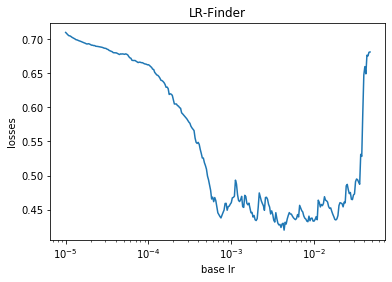

epoch 0: 	 Start training...


IndexError: Caught IndexError in DataLoader worker process 8.
Original Traceback (most recent call last):
  File "/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/robin/Projects/KaggleProjects/GoogleQuest/text_data.py", line 174, in __getitem__
    else: q_ids = q_ids[0]
IndexError: list index out of range


In [15]:
init_seed()
folds = GroupKFold(n_splits=5).split(
    X=train['question_body'], groups=train['question_body'])#KFold(n_splits=5, random_state=42).split(train)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_ds = TextDataset7(
        cat_features_train, ids_train['question'], ids_train['answer'], train_index, targets=y)
    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False, collate_fn=collate_fn, 
        sampler=LongestFirstRandomSampler(train_ds)
    )
    valid_ds = TextDataset7(
        cat_features_train, ids_train['question'], ids_train['answer'], valid_index, targets=y)
    valid_loader = DataLoader(
        valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False, collate_fn=collate_fn, 
        sampler=LongestFirstSequentialSampler(valid_ds)
    )
    model = CustomBert7(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
        del lr_finder
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / 5
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4134

In [24]:
for b in train_loader:
    b

IndexError: Caught IndexError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/robin/Projects/KaggleProjects/GoogleQuest/text_data.py", line 174, in __getitem__
    else: q_ids = q_ids[0]
IndexError: list index out of range


In [32]:
train_ds.__len__()

4863

In [36]:
train_ds.question_ids[i]

[]

In [33]:
for i in tqdm(range(len(train_ds))): 
    train_ds[i]

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


IndexError: list index out of range

In [ ]:
torch.tensor([[24,24],[43,21]]).max(dim=0).values

In [ ]:
[(i, train_loader.dataset[i][0][3]) for i in range(5, 15)]

In [ ]:
batch = [train_loader.dataset[i] for i in range(6,10)]

In [ ]:
T = lambda x: torch.tensor(x)
x_feats, q_ids, a_ids, n_q_seq, n_a_seq, targets = [], [], [], [], [], []
for b in batch:
    (x, q, a, n_q, n_a), t = b
    x_feats.append(x)
    q_ids.append(q)
    a_ids.append(a)
    n_q_seq.append(n_q)
    n_a_seq.append(n_a)
    targets.append(t)

x_feats = T(np.vstack(x_feats))
q_ids = T(np.vstack(q_ids))
a_ids = T(np.vstack(a_ids))
n_q_seq = T(np.array(n_q_seq))
n_a_seq = T(np.array(n_a_seq))
targets = T(np.vstack(targets))

In [ ]:
x_feats.shape, q_ids.shape, a_ids.shape, n_q_seq, n_a_seq, targets.shape

In [ ]:
x_feats.type(), q_ids.type(), a_ids.type(), n_q_seq.type(), n_a_seq.type(), targets.type()

In [ ]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

from scipy.stats import spearmanr
def spearmanr_np(preds, targets):
    score = 0
    for i in range(N_TARGETS):
        score_i = spearmanr(preds[:, i], targets[:, i]).correlation
        score += np.nan_to_num(score_i / N_TARGETS)
    return score

In [ ]:
zero_idx = np.where(y.mean(axis=0).round(3)<=0.001)[0][0]

In [ ]:
my_round(oofs, 3, 2), oofs

In [ ]:
spearmanr_np(oofs, y)

In [ ]:
spearmanr_np(np.clip(round_preds(oofs, high_num=3), 0.00001, 0.999999), y)

In [ ]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [ ]:
sample_submission.head()